In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#data slice for reviews
df=pd.read_json('reviews.json')   
temp=[i.strip() for i in df.iloc[:,3]]   

In [3]:
#delete punctuation
import string
exclude = set(string.punctuation)
reviews=[]
for i in range(len(temp)):
    reviews.append(''.join(ch for ch in temp[i] if ch not in exclude))  

In [4]:
#delete numbers
reviews1=[]
for i in range(len(temp)):

    reviews1.append(''.join(ch for ch in reviews[i] if not ch.isdigit()))  

In [5]:
#stem words
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
temp1=[]
temp2=[]
for i in range(len(reviews)):
    words = word_tokenize(reviews1[i])
    for word in words:
        temp1.append(stemmer.stem(word))
    temp2.append(temp1)
    temp1=[]

stemed_reviews=[]
for i in range(len(temp2)):
    a=' '.join(temp2[i])
    stemed_reviews.append(a)   

In [6]:
#get word bag
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
data = cv.fit_transform(stemed_reviews)
data=data.toarray()
word_bag_title=cv.get_feature_names()  
df.replace(to_replace=df['Review'].values,value=stemed_reviews,inplace=True)    

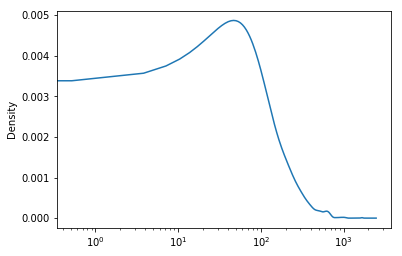

In [7]:
#EDA part
reviews=df.iloc[:, 3]   
review_lengths=reviews.apply(lambda r: len(r))
review_lengths.describe()
review_lengths.plot(kind='kde',logx=True)
plt.show()

Seems like the lenth of the reviews are not normal distributed, thus we won't use this as a feature.

In [8]:
#get DV and IV
x = data
y = df.iloc[:, 2].values    

In [9]:
#splitting the dataset into the sraining set and test set
from sklearn.model_selection import train_test_split             
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)    

RandomForest Algorithm

In [10]:
from sklearn.ensemble import RandomForestClassifier         
RFclassifier=RandomForestClassifier(random_state=0)
RFclassifier.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
#tuning parameters
from sklearn.model_selection import GridSearchCV
n_estimators_range=[10,100,500,1000]
max_depth_range=[None,5,8,15,30]
min_samples_split_range=[2,5,10,50,100]
min_samples_leaf_range=[1,2,5,10]
param_grid = dict(n_estimators=n_estimators_range, max_depth=max_depth_range, min_samples_leaf=min_samples_leaf_range, min_samples_split=min_samples_split_range)
grid = GridSearchCV(estimator=RFclassifier, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.673496 using {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.660691 (0.014919) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.669654 (0.010993) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.668374 (0.019322) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.665813 (0.014994) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.658131 (0.020479) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.670935 (0.012623) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.672215 (0.012580) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
0.670935 (0.014205) with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 

So we got the best parameters are max_depth:None, min_samples_leaf:1, min_samples_split:10 and n_estimators:100. And we can use these to get a new RF model with these parameters.

In [12]:
#predicting the test set result
RFclassifier=RandomForestClassifier(min_samples_leaf=1,min_samples_split=10,n_estimators=100,max_depth=None,random_state=1000)
RFclassifier.fit(x_train,y_train)
y_pred=RFclassifier.predict(x_test)

In [13]:
#making the Confusion Matrix
from sklearn.metrics import confusion_matrix
RFcm=confusion_matrix(y_test,y_pred)
print(RFcm)

[[ 11   0   0   0  14]
 [  2   0   1   0  10]
 [  0   0   0   2  10]
 [  0   0   1   0  32]
 [  1   0   1   0 111]]


In [14]:
#AUC of RandomForest
RFaccuracy=RFcm.trace()/RFcm.sum()
print(RFaccuracy)

0.6224489795918368


Logistic Regression Algorithm

In [15]:
from sklearn.linear_model import LogisticRegression     
LRclassifier=LogisticRegression(random_state=0)
LRclassifier.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
#tuning parameters
from sklearn.model_selection import GridSearchCV
penalty_range=['l1','l2']
C_range=[0.001,0.1,1,10,100]
param_grid = dict(penalty=penalty_range,C=C_range)
grid = GridSearchCV(estimator=LRclassifier, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.686300 using {'C': 1, 'penalty': 'l1'}
0.093470 (0.001393) with: {'C': 0.001, 'penalty': 'l1'}
0.641485 (0.003071) with: {'C': 0.001, 'penalty': 'l2'}
0.641485 (0.003071) with: {'C': 0.1, 'penalty': 'l1'}
0.673496 (0.009736) with: {'C': 0.1, 'penalty': 'l2'}
0.686300 (0.012694) with: {'C': 1, 'penalty': 'l1'}
0.678617 (0.011129) with: {'C': 1, 'penalty': 'l2'}
0.658131 (0.010686) with: {'C': 10, 'penalty': 'l1'}
0.674776 (0.009494) with: {'C': 10, 'penalty': 'l2'}
0.619718 (0.009147) with: {'C': 100, 'penalty': 'l1'}
0.649168 (0.007713) with: {'C': 100, 'penalty': 'l2'}


So we got the best parameters are C=1 and penalty=l1. And we can use these to get a new LR model with these parameters.

In [17]:
LRclassifier=LogisticRegression(C=1,penalty='l1',random_state=0)
LRclassifier.fit(x_train,y_train)
y_pred=LRclassifier.predict(x_test)

In [18]:
# making the Cofussion Matrix
from sklearn.metrics import confusion_matrix
LRcm=confusion_matrix(y_test,y_pred)
print(LRcm)

[[ 13   1   1   2   8]
 [  3   2   4   0   4]
 [  1   1   1   1   8]
 [  1   2   0   5  25]
 [  0   1   2   3 107]]


In [19]:
#AUC of Logistic Regression
LRaccuracy=LRcm.trace()/LRcm.sum()
print(LRaccuracy)

0.6530612244897959


SVM Algorithm

In [20]:
from sklearn.svm import SVC
SVCclassifier=SVC(random_state=0)
SVCclassifier.fit(x_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
#tuning parameters
from sklearn.model_selection import GridSearchCV
C_range=[0.0001,0.001,0.1,1,10,100,1000]
kernel_range=['rbf','linear']
param_grid = dict(kernel=kernel_range,C=C_range)
grid = GridSearchCV(estimator=SVCclassifier, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.670935 using {'C': 0.1, 'kernel': 'linear'}
0.641485 (0.003071) with: {'C': 0.0001, 'kernel': 'rbf'}
0.641485 (0.003071) with: {'C': 0.0001, 'kernel': 'linear'}
0.641485 (0.003071) with: {'C': 0.001, 'kernel': 'rbf'}
0.641485 (0.003071) with: {'C': 0.001, 'kernel': 'linear'}
0.641485 (0.003071) with: {'C': 0.1, 'kernel': 'rbf'}
0.670935 (0.009664) with: {'C': 0.1, 'kernel': 'linear'}
0.641485 (0.003071) with: {'C': 1, 'kernel': 'rbf'}
0.651729 (0.013545) with: {'C': 1, 'kernel': 'linear'}
0.642766 (0.004603) with: {'C': 10, 'kernel': 'rbf'}
0.608195 (0.021512) with: {'C': 10, 'kernel': 'linear'}
0.667093 (0.012472) with: {'C': 100, 'kernel': 'rbf'}
0.580026 (0.021238) with: {'C': 100, 'kernel': 'linear'}
0.644046 (0.014713) with: {'C': 1000, 'kernel': 'rbf'}
0.578745 (0.032119) with: {'C': 1000, 'kernel': 'linear'}


So we got the best parameters are C=0.1 and kernel=linear. And we can use these to get a new SVC model with these parameters.

In [22]:
SVCclassifier=SVC(kernel='linear',C=0.1,random_state=0)
SVCclassifier.fit(x_train,y_train)
y_pred=SVCclassifier.predict(x_test)

In [23]:
# making the Cofussion Matrix
from sklearn.metrics import confusion_matrix
SVMcm=confusion_matrix(y_test,y_pred)
print(SVMcm)

[[ 12   0   0   1  12]
 [  5   0   1   0   7]
 [  1   0   1   0  10]
 [  0   1   0   2  30]
 [  0   1   1   2 109]]


In [24]:
#AUC of SVM
SVMaccuracy=SVMcm.trace()/SVMcm.sum()
print(SVMaccuracy)

0.6326530612244898


The final result is the Logitic Regression algorithm has the highest accuraccy, which is about 65.31%.